# Imports

In [1]:
import os, torch, random
import SimpleITK, re
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import transforms, models
from torch.utils.data import DataLoader
import re
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [2]:
SEED = 2024

def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

## GPU

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Dataset

In [4]:
class OASIS_TemporalDataset(Dataset):
    def __init__(self, features, train, seed=7):
        self.train = train
        self.seed = seed
        self.selected_patients = self.split(features)
        
        id_day_map = {}
        id_day_feature_map = {}

        for patient_id, day, feature, label in zip(
            features['patient_id'], features['day'], 
            features['feature'], features['label']
        ):
            if patient_id not in self.selected_patients: continue
            
            if patient_id not in id_day_map:
                id_day_map[patient_id] = [day]
            else:    
                id_day_map[patient_id].append(day)
                
            id_day_feature_map[(patient_id, day)] = (feature, label)
            
        self.id_day_map = id_day_map
        self.id_day_feature_map = id_day_feature_map
        self.id_days = list(id_day_feature_map.keys())
        
    def split(self, features):
        patient_ids, labels = [], []
        for i in range(len(features['patient_id'])):
            patient_id = features['patient_id'][i]
        
            if patient_id in patient_ids: continue
            
            patient_ids.append(patient_id)
            # assuming same patient id and day can't be in both healthy and disease dir
            labels.append(features['label'][i])
        
        train_ids, test_ids = train_test_split(
            patient_ids, test_size=0.2, shuffle=True, 
            random_state=self.seed, stratify=labels
        )
        
        if self.train: return train_ids
        else: return test_ids
        
    def __len__(self):
        return len(self.id_days)
    
    def __getitem__(self, idx):
        id, current_day = self.id_days[idx]
        
        # sort the current and previous days in ascending order
        prev_days = sorted([day for day in self.id_day_map[id] if day <= current_day])
        
        # get feature for each previous day
        features = np.array([self.id_day_feature_map[(id, d)][0] for d in prev_days]    )
        
        # predict the label for the current day
        label = self.id_day_feature_map[(id, current_day)][1]
        
        return torch.tensor(features), torch.tensor(label)

# Model

In [5]:
class LstmModel(torch.nn.Module):
    def __init__(
        self, input_size=512, num_layers=1, 
        hidden_size=64, output_size=2, dropout=0.1
    ):
        super(LstmModel, self).__init__()
        # input shape is (batch, seq_len, features)
        self.lstm = torch.nn.LSTM(
            input_size=input_size, 
            hidden_size= hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # The output of nn.LSTM() is a tuple. The first 
        # element is the generated hidden states, 
        # one for each time step of the input. The 
        # second element is the LSTM cell’s memory 
        # and hidden states, which is not used here.
        # output (batch x hidden_size), (hc, cn)
        x, _ = self.lstm(x) 
        
        # The output of hidden states is further processed by a 
        # fully-connected layer to produce a single regression result. 
        # Since the output from LSTM is one per each input time step, 
        # you can chooce to pick only the last timestep’s output
        # x = self.fc(x[:, -1, :])
        x = self.fc(self.dropout(x[:, -1]))
        
        return x

# Experiment

## Result dir

In [6]:
result_dir = os.path.join('OASIS_2D', 'scratch', 'ResNet')

if not os.path.exists(result_dir):
    os.makedirs(result_dir, exist_ok=True)

## Load extracted features

In [7]:
# features = {
#     'patient_id': total_dataset.patient_ids,
#     'day': total_dataset.days,
#     'label': total_dataset.labels,
#     'feature': all_outputs
# }

features = torch.load(os.path.join(result_dir, 'features.pt'))

dimension = len(features['feature'][0])
print(f'Extracted feature has dimension {dimension}')

Extracted feature has dimension 512


## Dataloader

### Util

In [63]:
def collate_fn(data, max_len=None):
    """Build mini-batch tensors from a list of (X, mask) tuples. Mask input. Create
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (num_labels,) : class indices or numerical targets
                (for classification or regression, respectively). num_labels > 1 for multi-task models
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        targets: (batch_size, padded_length, feat_dim) torch tensor of unmasked features (output)
        target_masks: (batch_size, padded_length, feat_dim) boolean torch tensor
            0 indicates masked values to be predicted, 1 indicates unaffected/"active" feature values
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 means padding
    """

    batch_size = len(data)
    features, labels = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)
    for i in range(batch_size):
        end = min(lengths[i], max_len)
        # X[i, :end, :] = features[i][:end, :]
        # keep the most recent time steps
        # previous implementation was truncating the last few time steps if goes beyond max_len
        X[i, :end, :] = features[i][-end:, :] 

    targets = torch.stack(labels, dim=0)  # (batch_size, num_labels)

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16),
                                 max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep

    return X, targets, padding_masks


def padding_mask(lengths, max_len=None):
    """
    Used to mask padded positions: creates a (batch_size, max_len) boolean mask from a tensor of sequence lengths,
    where 1 means keep element at this position (time step)
    """
    batch_size = lengths.numel()
    max_len = max_len or lengths.max_val()  # trick works because of overloading of 'or' operator for non-boolean types
    
    mask = (torch.arange(0, max_len, device=lengths.device)
            .type_as(lengths)
            .repeat(batch_size, 1)
            .lt(lengths.unsqueeze(1)))
    return mask

### Create

In [64]:
train_dataset = OASIS_TemporalDataset(features, train=True, seed=SEED)
test_dataset = OASIS_TemporalDataset(features, train=False, seed=SEED)

In [65]:
batch_size = 8
seq_len = 3

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=args.num_workers,
    # drop_last=drop_last,
    collate_fn=lambda x: collate_fn(x, max_len=seq_len)
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False, # shuffling not necessary for test
    # num_workers=args.num_workers,
    # drop_last=drop_last,
    collate_fn=lambda x: collate_fn(x, max_len=seq_len)
)

## Sequence length

In [15]:
import pandas as pd
import seaborn as sns

lengths = [ item[0].shape[0] for item in train_dataset]
df = pd.DataFrame(lengths, columns=['lengths'])

### Count plot

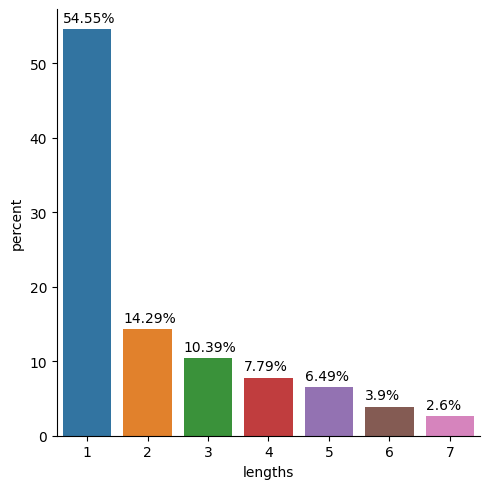

In [16]:
counts = df.value_counts(normalize=True) * 100
counts = counts.rename('percent').reset_index()

g = sns.catplot(x='lengths',y='percent',kind='bar',data=counts)
# g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y+1,txt)

### Distribution plot

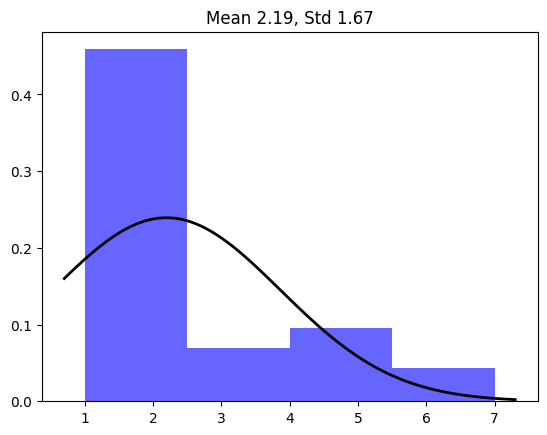

In [17]:
from scipy.stats import norm

# Generate some data for this 
# demonstration.
data = np.array(lengths)

# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(data) 

# Plot the histogram.
plt.hist(data, bins=4, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Mean {:.2f}, Std {:.2f}".format(mu, std)
plt.title(title)

plt.show()

## Train

In [74]:
model = LstmModel(num_layers=3, dropout=0.1)
model.float().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()
early_stopping = EarlyStopping(patience=10, verbose=False, dirpath=result_dir)

scheduler = ReduceLROnPlateau(
    optimizer, 'min', 
    patience=3, min_lr=1e-6, verbose=True
)
n_epochs = 100

for epoch in range(n_epochs):
    total_loss = []
    total_probs, total_preds, total_labels = [], [], []
    model.train()
    # training batch_x, label, padding_masks
    for (x_train, y_train, padding_masks) in train_dataloader:
        x_train, y_train = x_train.float().to(device), y_train.float().to(device)
        outputs = model(x_train)
        loss = criterion(outputs.squeeze(), y_train)
        optimizer.zero_grad()
        
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        probs = torch.sigmoid(outputs)
        # preds = torch.argmax(probs, dim=1)
        preds = probs[:, -1].round()

        # comvert to numpy
        probs = probs.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()

        # append to list
        total_labels.extend(y_train.detach().cpu().numpy())
        total_probs.extend(probs[:, -1])
        total_preds.extend(preds)
        
    train_loss = np.mean(total_loss)
    
    # validation
    model.eval()
    total_loss = []
    
    with torch.no_grad():
        for (x_test, y_test, padding_masks) in test_dataloader:
            x_test, y_test = x_test.float().to(device), y_test.float().to(device)
            outputs = model(x_test)
            loss = criterion(outputs.squeeze(), y_test)
            total_loss.append(loss.item())
        
    val_loss = np.mean(total_loss)    
        
    if epoch % 2 == 0:
        # calculate metrics
        acc = accuracy_score(total_labels, total_preds)
        auc = roc_auc_score(total_labels, total_probs)
        f1 = f1_score(total_labels, total_preds)
        
        # print metrics
        print(
            f'Epoch {epoch+1}: train loss {train_loss:0.4g} val loss {val_loss:0.4g} acc {acc:0.4g} f1 {f1:0.4g} auc {auc:0.4g}'
        )
        
    # early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    scheduler.step(val_loss)

Epoch 1, train loss 0.6826 val_loss 0.6846 acc 0.5195 f1 0 auc 0.6764
Epoch 3, train loss 0.5353 val_loss 0.6515 acc 0.5455 f1 0.1026 auc 0.9473
Epoch 5, train loss 0.3741 val_loss 0.6798 acc 0.8831 f1 0.8889 auc 0.9203
Epoch 7, train loss 0.3494 val_loss 0.6642 acc 0.8442 f1 0.8571 auc 0.8838
Epoch 9, train loss 0.3242 val_loss 0.6444 acc 0.8701 f1 0.875 auc 0.95
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11, train loss 0.2652 val_loss 0.7621 acc 0.8961 f1 0.9024 auc 0.9736
Epoch 13, train loss 0.2599 val_loss 0.771 acc 0.8961 f1 0.9024 auc 0.9716
Epoch 00014: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15, train loss 0.2476 val_loss 0.7897 acc 0.8961 f1 0.9024 auc 0.9885
Early stopping


In [75]:
model.eval()
total_loss = []
total_probs, total_preds, total_labels = [], [], []

with torch.no_grad():
    for (x_test, y_test, padding_masks) in test_dataloader:
        x_test, y_test = x_test.float().to(device), y_test.float().to(device)
        outputs = model(x_test)
        loss = criterion(outputs.squeeze(), y_test)
        total_loss.append(loss.item())
        
        probs = torch.sigmoid(outputs)
        preds = probs[:, -1].round() # torch.argmax(probs, dim=1)

        # comvert to numpy
        probs = probs.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()

        # append to list
        total_labels.extend(y_test.detach().cpu().numpy())
        total_probs.extend(probs[:, -1])
        total_preds.extend(preds)
    
test_loss = np.mean(total_loss)     
acc = accuracy_score(total_labels, total_preds)
auc = roc_auc_score(total_labels, total_probs)
f1 = f1_score(total_labels, total_preds)

# print metrics
print(
    f'f1 {f1:0.4g} acc {acc:0.4g} auc {auc:0.4g}'
)

f1 0.75 acc 0.7391 auc 0.7692
